# 6 The missing piece: non-linearity
What patterns could you draw if you had a high amount of staight and non-straight lines? or linear and non linear functions

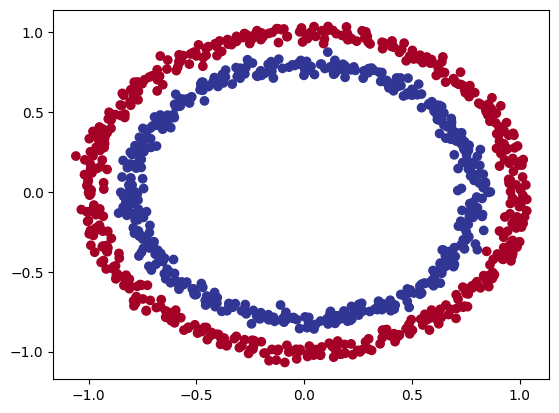

In [1]:
# imports 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [2]:
# convert to tensors and then train and test data
import torch as pt
from sklearn.model_selection import train_test_split

X = pt.from_numpy(X).type(pt.float)
y = pt.from_numpy(y).type(pt.float)

# Split int otrain and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [3]:
device = "cuda" if pt.cuda.is_available() else "cpu"

### 6.2 Building a model with non-linearity (curved lines)
info on chosen for this example: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [4]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # ReLu is a non linear activation function
    def forward(self, X):
        return self.layer_3(self.layer_2(self.relu(self.layer_1(X))))
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [5]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = pt.optim.SGD(params=model_3.parameters(), lr=0.1)


# Calculate accuracy, how meny of the the examples the model gets right
def accuracy_fn(y_preds, y_true):
    """tar antalet där y_true == y_preds
    
    Tar detta värdet delat med det hela alltså y_pred * 100 för att få % enheten av gissningar som är rätt"""
    correct = pt.eq(y_true, y_preds).sum().item() # sum tar summan av alla true som även kan ses som 1. item gör sedan om denna summerade siffra från tensor till nummer
    acc = (correct/len(y_preds)) * 100 # delen delat med det hela
    return acc

In [16]:
# Training the model

# Random seeds 
pt.manual_seed(42)
pt.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)

X_test, y_test = X_test.to(device), y_test.to(device)

print(X_test.dtype)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    print(y_logits)
    y_preds = pt.round(pt.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_preds, y_train)
    
    optimizer.zero_grad()

    loss.backward() # backwards propogation

    optimizer.step() # gradient descend

    model_3.eval()
    with pt.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = pt.round(pt.sigmoid(test_logits))
        test_loss = loss_fn(test_preds, y_test)
        test_acc = accuracy_fn(test_preds, y_test)
    if epoch % 100 == 0:
        print(f"train loss: {loss}, train acc: {train_acc},  test loss: {test_loss}, test acc: {test_acc}")



torch.float32
tensor([ 1.6683e+00, -6.0227e-01, -1.7016e+00, -1.4536e+00,  1.1358e+00,
        -1.0368e+00,  9.8101e-01,  1.4037e+00, -2.7676e-01, -1.2391e+00,
         8.9507e-01, -6.6221e-01, -1.4739e+00, -3.6229e-01,  5.5258e-01,
        -8.1581e-01, -1.6097e+00, -6.8536e-01, -1.3253e+00,  1.4954e+00,
         1.7706e+00,  1.7134e+00, -2.0037e+00,  7.1781e-01,  7.3294e-01,
         4.5866e-01, -1.9669e+00, -7.2057e-01, -7.3853e-02, -4.0418e-01,
        -1.2383e+00, -1.8095e+00, -2.0431e+00,  1.2917e+00, -1.7653e+00,
        -5.3079e-01,  1.1239e+00,  7.5905e-01,  9.4416e-01,  1.1358e+00,
         9.7585e-01,  9.9240e-01, -1.4601e+00,  1.6977e+00, -1.6170e+00,
         1.1885e+00, -1.5830e+00, -8.7184e-01, -9.5915e-01, -4.0541e-01,
        -1.1771e+00,  1.0428e-01, -7.9482e-01,  8.4689e-01,  5.4073e-01,
         8.2981e-01, -5.4739e-01,  1.4923e+00,  1.1038e+00,  7.4247e-01,
        -1.1188e+00, -2.2246e+00, -1.6813e+00,  1.4336e+00, -1.5644e+00,
        -7.5118e-01,  1.4570e+00, -4.

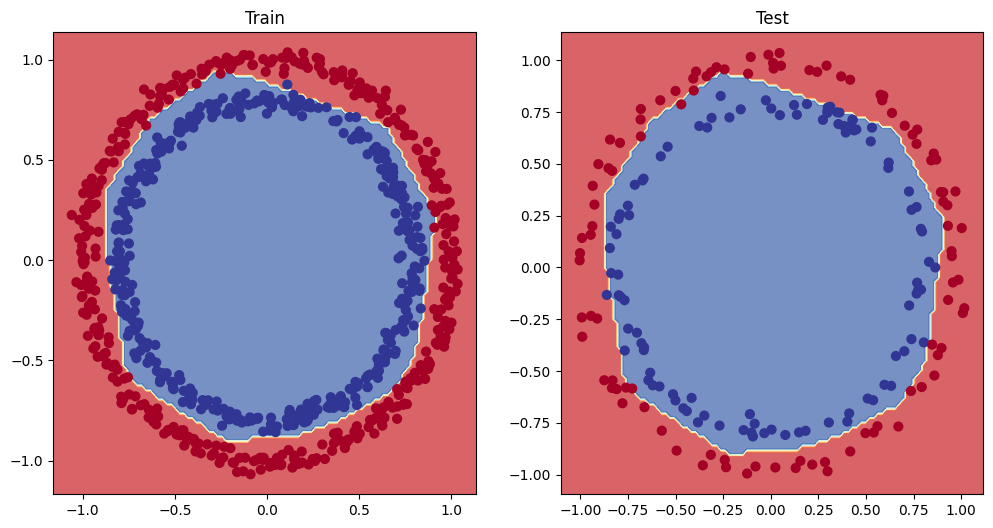

In [15]:
from helper_functions import plot_decision_boundary
def view_results(X_train, y_train, X_test, y_test, model):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1,2,2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)
view_results(X_train, y_train, X_test, y_test, model_3)